In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read DataFrame from Excel
df_raw = pd.read_excel("1.xlsm", sheet_name = "injection")
df_raw.drop(df_raw[0:11].index, inplace=True)
df_raw.reset_index(inplace=True, drop=True)

# Steps for loops
step_for_vertical_loop = int(df_raw.shape[0]/4)
range_for_horizontal_loop = len(df_raw.columns)-9

# Injection well list for classes
inj_well_list = []

# Timestamp from relevant data inputs
timestamp_filter = pd.Timestamp(2020, 6, 1, 0)

In [3]:
# Injection well class

class Inj_Well():
    
    def __init__(self, well, date, inj_rate, whp):
        
        self.well = well
        self.date = date
        self.inj_rate = inj_rate
        self.whp = whp
        self.counter = None
        self.c_injection = []
        self.c_whp = []
    
    # Delete NaN values in lists
    
    def delete_nan(self):
        
        list_to_delete = []
        
        for i in range(len(self.date)):
            if pd.isnull(self.inj_rate[i]):
                list_to_delete.append(i)
        
        self.date = [i for j, i in enumerate(self.date) if j not in list_to_delete]
        self.inj_rate = [i for j, i in enumerate(self.inj_rate) if j not in list_to_delete]
        self.whp = [i for j, i in enumerate(self.whp) if j not in list_to_delete]
     
    # Create day counter list
    
    def create_counter(self):
        self.counter = [i for i in range(len(self.date))]
    
    # Convert list elements to float format
    
    def convert_to_float(self):
        
        self.inj_rate = map(float, self.inj_rate)
        self.whp = map(float, self.whp)
        
        self.whp = list(self.whp)                 
        self.inj_rate = list(self.inj_rate)            
      
    # Filtering data before 2020-06-01

    def timestamp_filtering(self):
        
        count = len([i for i in self.date if i < timestamp_filter])
                
        self.date = self.date[count:]
        self.inj_rate = self.inj_rate[count:]
        self.whp = self.whp[count:]
        
    # Additional individual timestamp filter
    
    def individual_timestamp_filter(self, well_name, date):
        
        if self.well == int(well_name):
            
            count = len([i for i in self.date if i < date])
            self.date = self.date[count:]
            self.inj_rate = self.inj_rate[count:]
            self.whp = self.whp[count:]
        
    # Calculate cumulative injection and pressure
    
    def calculate_cumulative(self):
        
        c_sum_inj = 0
        c_sum_whp  = 0
        
        for i in self.inj_rate:
            c_sum_inj += i
            self.c_injection.append(c_sum_inj)
            
        for j in self.whp:
            c_sum_whp += j
            self.c_whp.append(c_sum_whp)

In [4]:
# Parsing and create inj well classes

for i in range(step_for_vertical_loop):
    
    inj_rate = []
    whp = []
    
    well_name = df_raw.iloc[1+i*4][5]
    date = pd.date_range(datetime(2019, 4, 1), periods=range_for_horizontal_loop).tolist()
    for j in range(range_for_horizontal_loop):
        
        inj_rate_value = df_raw.iloc[1+i*4][j+9]
        whp_value = df_raw.iloc[2+i*4][j+9]
        
        inj_rate.append(inj_rate_value)
        whp.append(whp_value)
        
    inj_well = Inj_Well(well=well_name, date=date, inj_rate=inj_rate,  whp=whp)
    inj_well_list.append(inj_well)

In [5]:
# Delete empty days, create counter and cumulative sums

for well in inj_well_list:
    well.delete_nan()
    well.convert_to_float()
    well.timestamp_filtering()
    well.individual_timestamp_filter(well_name = 14, date = pd.Timestamp(2021, 2, 1, 0))
    well.create_counter()
    well.calculate_cumulative()

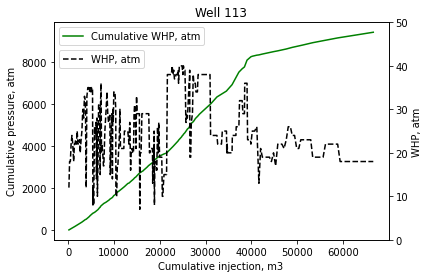

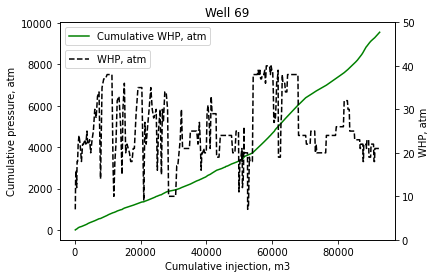

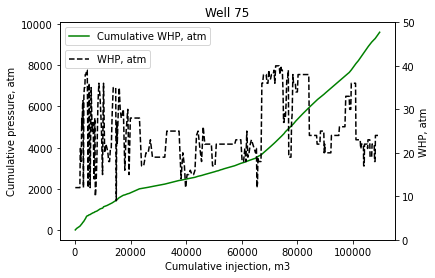

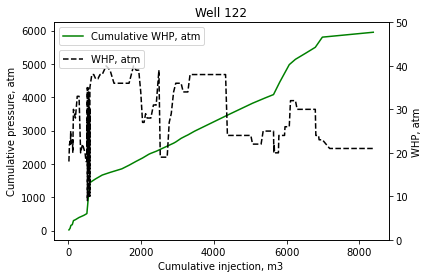

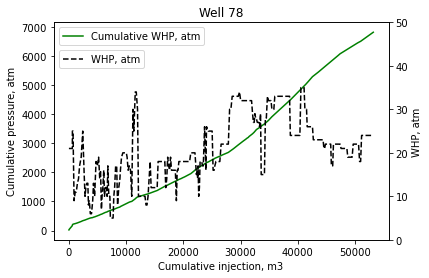

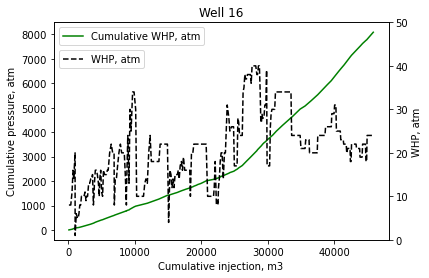

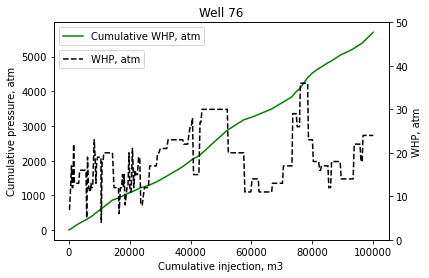

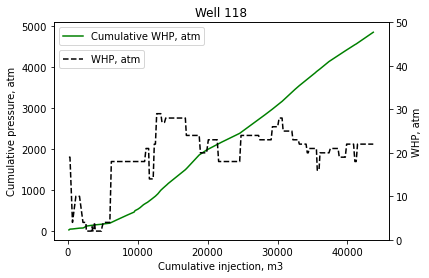

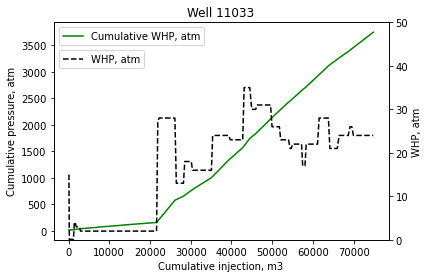

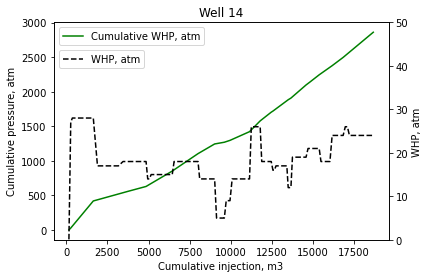

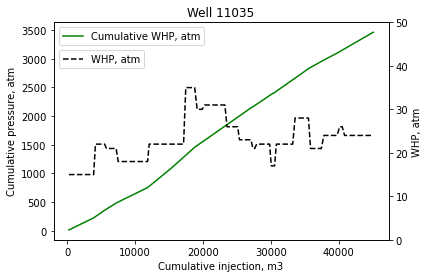

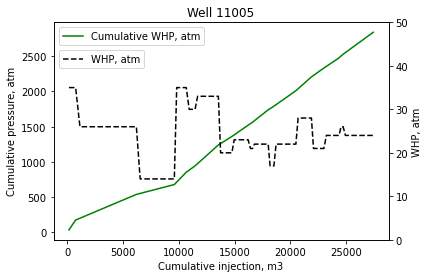

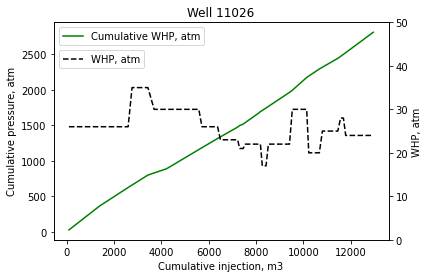

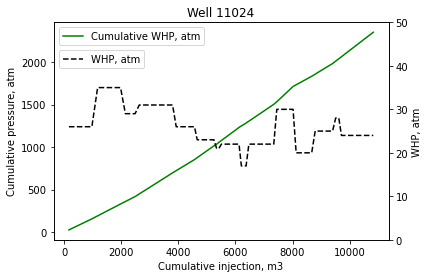

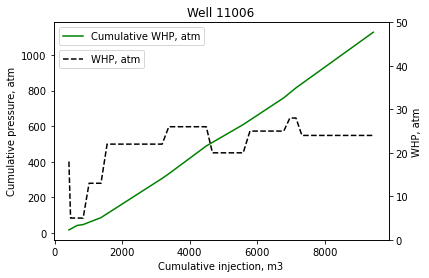

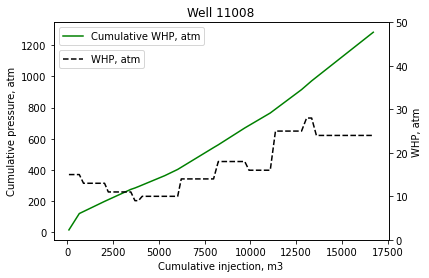

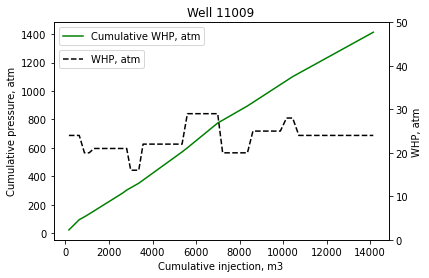

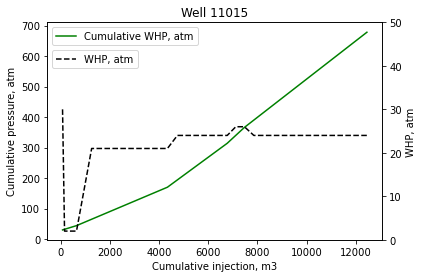

In [7]:
# Plotting and exporting 

for i in range(len(inj_well_list)):
    
    x = inj_well_list[i].c_injection
    y = inj_well_list[i].c_whp
    z = inj_well_list[i].whp
    time = inj_well_list[i].date
    
    well_name = 'Well '+str(inj_well_list[i].well)
    
    fig, ax = plt.subplots()
    plt.plot(x, y, 'g', label = 'Cumulative WHP, atm')
    plt.legend(loc="best")
    
    plt.xlabel("Cumulative injection, m3")
    plt.ylabel("Cumulative pressure, atm")
    
    plt.title(well_name)
    
    ax2 = ax.twinx()
    ax2.set_ylim(0,50)
    plt.plot(x, z, '--k', label = 'WHP, atm')
    plt.legend(loc=(0.015, 0.79))
    
    plt.ylabel("WHP, atm")
    
    plt.savefig(("hall_plots/"+well_name+' Hall plot'+'.png'), dpi=300, bbox_inches='tight')

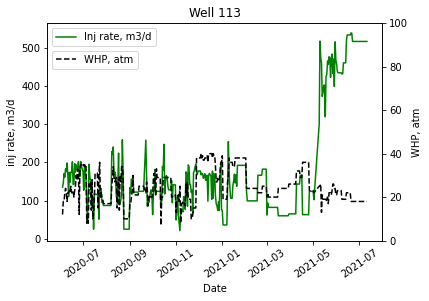

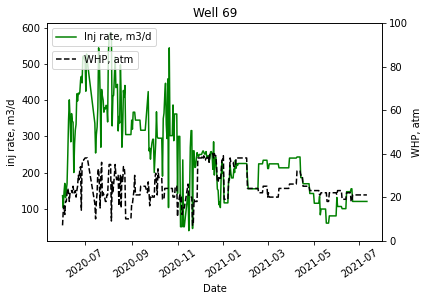

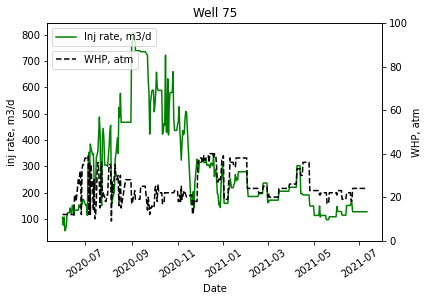

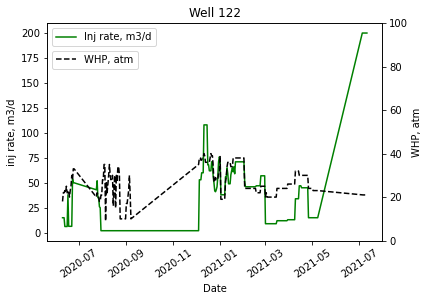

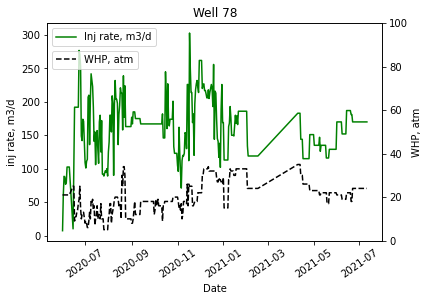

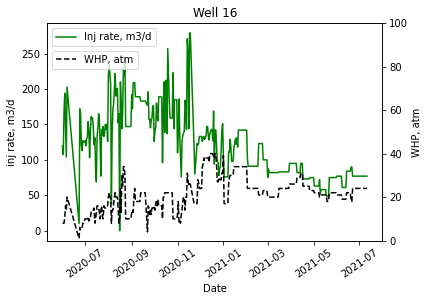

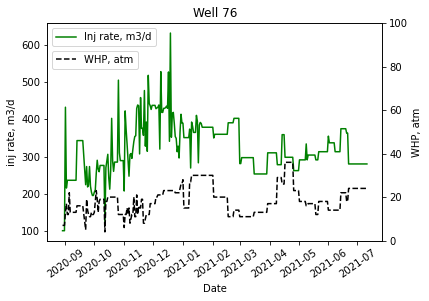

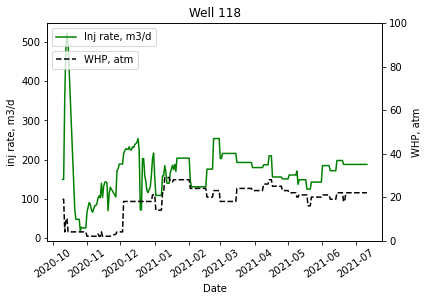

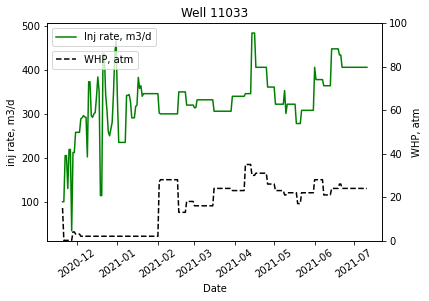

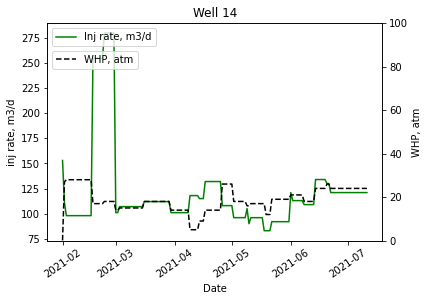

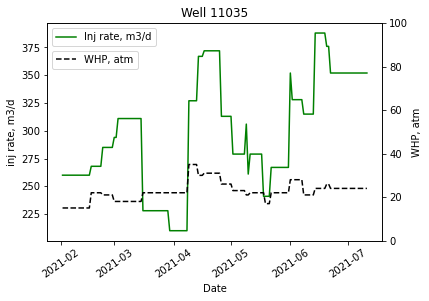

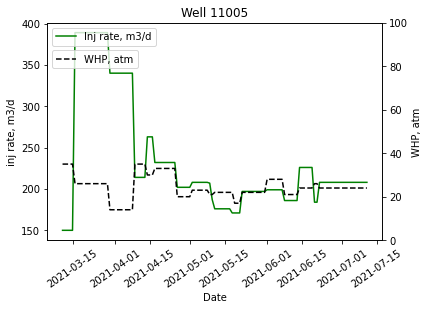

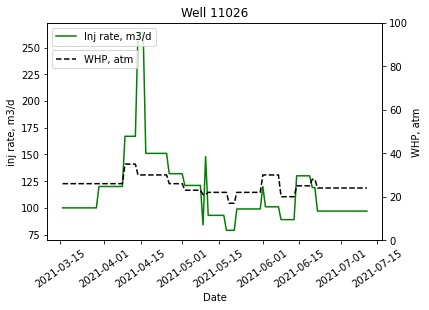

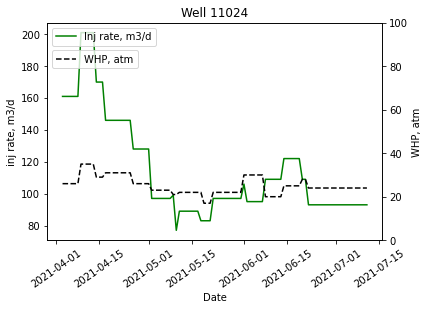

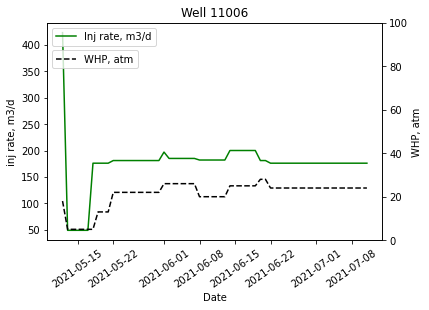

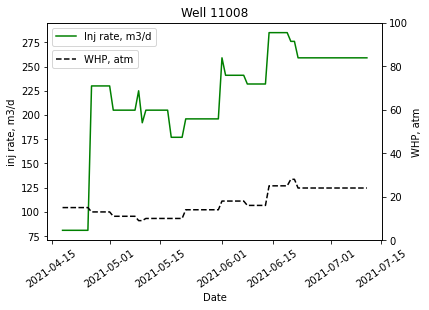

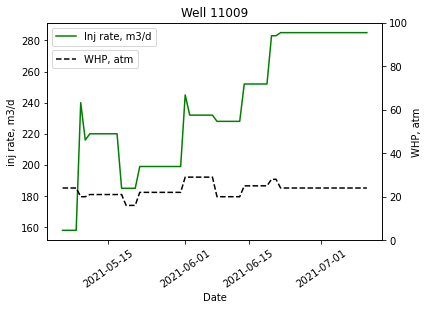

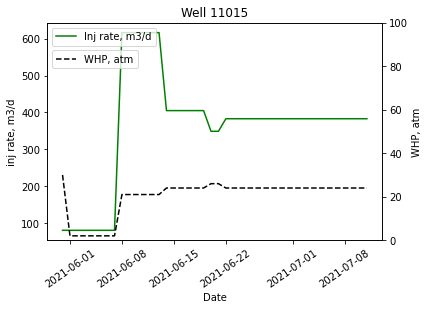

In [8]:
# Plotting and exporting

for i in range(len(inj_well_list)):
    
    x = inj_well_list[i].inj_rate
    y = inj_well_list[i].c_whp
    z = inj_well_list[i].whp
    time = inj_well_list[i].date
    
    well_name = 'Well '+str(inj_well_list[i].well)
    
    fig, ax = plt.subplots()
    plt.plot(time, x, 'g', label = 'Inj rate, m3/d')
    plt.legend(loc="upper left")
    
    plt.xlabel("Date")
    plt.ylabel("inj rate, m3/d")
    
    plt.xticks(rotation = 35)    
    plt.title(well_name)
    
    ax2 = ax.twinx()
    ax2.set_ylim(0,100)
    plt.plot(time, z, '--k', label = 'WHP, atm')
    plt.legend(loc=(0.015, 0.79))
    
    plt.ylabel("WHP, atm")
    
    plt.savefig("hall_plots/"+well_name+' Time plot'+'.png', dpi=300, bbox_inches='tight')

In [9]:
# Exporting to Excel

for well in inj_well_list:
    
    df_well = pd.DataFrame({
        
        'Data' : well.date,
        'Counter' : well.counter,
        'Inj rate, m3/day' : well.inj_rate,
        'WHP, atm' : well.whp,
        'c_INJ, m3' : well.c_injection,
        'c_WHP, atm' : well.c_whp
                           })
    
    file_name = "hall_plots\Well " + str(well.well) +".xlsx"
    df_well.to_excel(file_name)